In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [10]:
# Set a seed for reproducibility
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [11]:
def fetch_data(train_batch_size, test_batch_size):
    # Load MNIST dataset
    train_data = datasets.MNIST('data', train=True, download=True,
                                  transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)

    test_data = datasets.MNIST('data', train=False, download=True,
                                 transform=transforms.Compose([transforms.ToTensor()]))
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader


In [12]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(784, 10)
        self.layer2 = nn.Linear(10, 20)
        self.layer3 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [13]:
def evaluate_model(model, data_loader, loss_function):
    correct_predictions = 0
    total_samples = 0
    total_loss = 0
    batch_count = 0

    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            output = model(images.view(-1, 784))
            loss = loss_function(output, labels)
            total_loss += loss.item()
            batch_count += 1

            predictions = torch.argmax(output, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / batch_count
    accuracy = correct_predictions / total_samples
    return avg_loss, round(accuracy, 3)


In [14]:
def train_model(model, epochs):
    model.train()
    metrics_df = pd.DataFrame()

    for epoch in range(epochs):
        for _, (images, labels) in enumerate(train_loader):
            images, labels = Variable(images), Variable(labels)
            optimizer.zero_grad()
            predictions = model(images.view(-1, 784))
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()

        epoch_weights = pd.DataFrame()
        for name, param in model.named_parameters():
            if 'weight' in name:
                weights_vector = torch.nn.utils.parameters_to_vector(param).detach().numpy()
                epoch_weights = pd.concat([epoch_weights, pd.DataFrame(weights_vector).T], axis=1)

        metrics_df = pd.concat([metrics_df, epoch_weights], axis=0)
        train_loss, train_accuracy = evaluate_model(model, train_loader, loss_function)
        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)

    return metrics_df




In [15]:
# Parameters
train_batch_size = 1000
test_batch_size = 1000
train_loader, test_loader = fetch_data(train_batch_size, test_batch_size)
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
max_epochs = 45
all_metrics_df = pd.DataFrame()

loss_function = nn.CrossEntropyLoss()

for run in range(8):
    print(f"Run: {run}")
    model = SimpleNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-4)

    run_metrics = train_model(model, max_epochs)
    all_metrics_df = pd.concat([all_metrics_df, run_metrics], ignore_index=True)


Run: 0
Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7


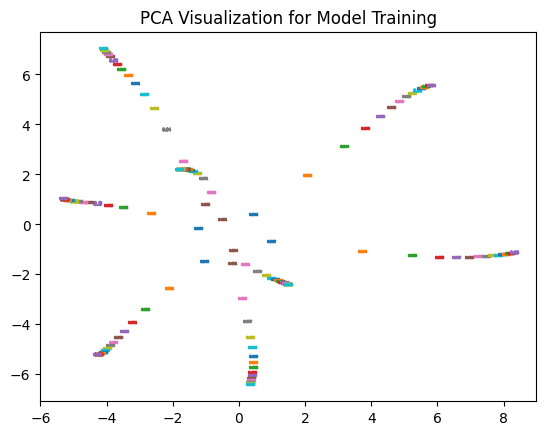

In [19]:
# PCA Visualization for Model
metrics_array = all_metrics_df.to_numpy()
pca_model = PCA(n_components=2)
transformed_data = pca_model.fit_transform(metrics_array)
results_df = pd.DataFrame(transformed_data, columns=['x', 'y'])
results_df['Accuracy'] = train_accuracy_history
results_df['Loss'] = train_loss_history

# Plotting
final_results_df = results_df.iloc[::3, :]  # Selecting every third row
num_points = len(final_results_df)  # Get the number of points available

# Adjusting the loop to avoid IndexError
for i in range(num_points):
    accuracy_value = final_results_df['Accuracy'].iloc[i]
    plt.scatter(final_results_df['x'].iloc[i], final_results_df['y'].iloc[i], marker=f'${accuracy_value}$')

plt.title("PCA Visualization for Model Training")
plt.show()


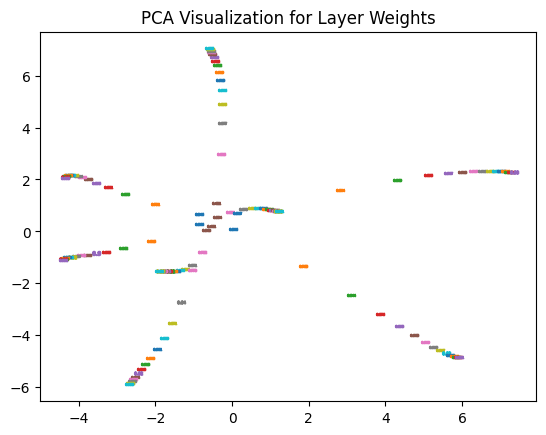

In [20]:
# PCA for layer weights
layer_weights_df = all_metrics_df.iloc[:, :7840]
layer_weights_array = layer_weights_df.to_numpy()
pca_layer_model = PCA(n_components=2)
layer_transformed_data = pca_layer_model.fit_transform(layer_weights_array)
layer_results_df = pd.DataFrame(layer_transformed_data, columns=['x', 'y'])
layer_results_df['Accuracy'] = train_accuracy_history
layer_results_df['Loss'] = train_loss_history

# Select every third row for final results
final_layer_results_df = layer_results_df.iloc[::3, :]
num_points = len(final_layer_results_df)  # Get the number of points available

# Adjusting the loop to avoid IndexError
for i in range(num_points):
    accuracy_value = final_layer_results_df['Accuracy'].iloc[i]
    plt.scatter(final_layer_results_df['x'].iloc[i], final_layer_results_df['y'].iloc[i], marker=f'${accuracy_value}$')

plt.title("PCA Visualization for Layer Weights")
plt.show()
